python=3.8
tf=2.10

**Imports**

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import csv
import math
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.layers import Embedding, LSTM, Dense, Flatten, Reshape, Dropout, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from keras import backend as K
from keras.constraints import MinMaxNorm
from keras.callbacks import LearningRateScheduler, EarlyStopping, Callback
from keras.metrics import RootMeanSquaredError
from keras.layers import Dropout,  TimeDistributed
from keras.regularizers import l2
from keras.initializers import HeNormal
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Concatenate
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, optimizers, losses, metrics
import cmocean
tf.keras.backend.set_floatx('float64')

**Check to see if CUDA can find my GPU**

In [2]:
len(tf.config.list_physical_devices('GPU'))>0

True

**Read csv file into a df and drop 'zCOM' column as it's not needed**

In [9]:
sorted_concatenated_csv = "C:/Users/Ioannis/Documents/UvA thesis/UvA-thesis/data/test_data_concat/final run concat 100x100.csv"
data = pd.read_csv(sorted_concatenated_csv)
#data.drop(columns=['zCOM'], inplace=True)
print(data.head())

   mcsteps  xCOM  yCOM              il8   il1   il6  il10   tnf   tgf
0        0    78    62   [8.155469e-08]  [0.]  [0.]  [0.]  [0.]  [0.]
1        0    29    17   [3.716848e-09]  [0.]  [0.]  [0.]  [0.]  [0.]
2        0    64    24  [3.4276149e-09]  [0.]  [0.]  [0.]  [0.]  [0.]
3        0    77    16  [3.7302027e-13]  [0.]  [0.]  [0.]  [0.]  [0.]
4        0    29     7  [3.9552712e-16]  [0.]  [0.]  [0.]  [0.]  [0.]


**Replace the 'mcsteps' column with 'time' and adjust the scale to represent 0-100 hours**

In [10]:
data['time'] = (data['mcsteps'] / 10000).astype(int)
data = data[['time'] + [col for col in data.columns if col != 'time']]
data.drop(columns=['mcsteps'], inplace=True)
print(data)

       time  xCOM  yCOM              il8              il1              il6  \
0         0    78    62   [8.155469e-08]             [0.]             [0.]   
1         0    29    17   [3.716848e-09]             [0.]             [0.]   
2         0    64    24  [3.4276149e-09]             [0.]             [0.]   
3         0    77    16  [3.7302027e-13]             [0.]             [0.]   
4         0    29     7  [3.9552712e-16]             [0.]             [0.]   
...     ...   ...   ...              ...              ...              ...   
33842   100    97    49  [1.4131037e-10]  [4.0171866e-09]  [4.0206436e-12]   
33843   100    62    90   [9.426965e-08]    [5.53244e-09]  [2.3352102e-08]   
33844   100     5    83   [3.467103e-11]   [1.923624e-08]   [4.866993e-11]   
33845   100    32    17  [1.6327994e-07]  [1.9637703e-09]  [4.1984766e-10]   
33846   100    86    51   [9.620416e-07]   [6.637888e-10]  [1.8478708e-13]   

                  il10              tnf               tgf  
0  

**Check for value ranges of the 6 cytokine columns**

In [11]:
cytokine_columns = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']
smallest_values = data[cytokine_columns].min()
largest_values = data[cytokine_columns].max()

print("Smallest values for each cytokine:")
print(smallest_values)
print("\nLargest values for each cytokine:")
print(largest_values)

Smallest values for each cytokine:
il8     [0.]
il1     [0.]
il6     [0.]
il10    [0.]
tnf     [0.]
tgf     [0.]
dtype: object

Largest values for each cytokine:
il8     [9.999916e-07]
il1     [9.999936e-10]
il6          [9.9e-43]
il10     [9.99949e-32]
tnf     [9.999565e-08]
tgf     [9.999223e-13]
dtype: object


**Replace negative 'il8' values with 0s (no need to run this after we fixed negative values)**

In [6]:
def replace_negative_with_zero(data):
    num_negative_values = (data < 0).sum().sum()
    data[data < 0] = 0

    return num_negative_values

cytokine_columns = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']

for col in cytokine_columns:
    num_negatives = replace_negative_with_zero(data[col])
    print(f"Number of negative values replaced with 0 in '{col}': {num_negatives}")

Number of negative values replaced with 0 in 'il8': 7147
Number of negative values replaced with 0 in 'il1': 0
Number of negative values replaced with 0 in 'il6': 0
Number of negative values replaced with 0 in 'il10': 0
Number of negative values replaced with 0 in 'tnf': 0
Number of negative values replaced with 0 in 'tgf': 0


C:\Users\Ioannis\AppData\Local\Temp\ipykernel_5860\3859886154.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data < 0] = 0
C:\Users\Ioannis\AppData\Local\Temp\ipykernel_5860\3859886154.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data < 0] = 0
C:\Users\Ioannis\AppData\Local\Temp\ipykernel_5860\3859886154.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data < 0] = 0
C:\Users\Ioannis\AppData\Local\Temp\ipyk

**Create 101 arrays (1 per timestep) to prepare the data to be input into a sequential model**

In [12]:
# define cytokines
cytokines = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']

# Remove brackets and convert to float
for col in cytokines:
    data[col] = data[col].str.strip('[]').astype(float)

# get unique time values
unique_time = data['time'].unique()

arrays = {}

# iterate over unique time values
for time in unique_time:
    # filter data for current value of time
    data_time = data[data['time'] == time]
    
    # initialize 50x50x6 array for current value of time
    array = np.zeros((100, 100, len(cytokines)))
    
    # get X and Y coordinates
    x = data_time['xCOM'].astype(int)
    y = data_time['yCOM'].astype(int)
    
    # get cytokine concentrations
    concentrations = data_time[['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']].values
    
    # assign cytokine concentrations to corresponding position in array
    array[x, y, :] = concentrations
    
    # store array for current value of time
    arrays[time] = array

**Run this cell if you want to normalize the values with minmax scaler per timestep, per cytokine while creating arrays**

In [23]:
cytokines = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']
concentrations_all = data[cytokines].values

scaler = MinMaxScaler()

scaler.fit(concentrations_all)

unique_time = data['time'].unique()

arrays = {}
scalers = {cytokine: MinMaxScaler() for cytokine in cytokines}
for time in unique_time:
    data_time = data[data['time'] == time]
    
    # Initialize 50x50x6 array for current value of time
    array = np.zeros((50, 50, len(cytokines)))
    
    # Get X and Y coordinates
    x = data_time['xCOM'].astype(int)
    y = data_time['yCOM'].astype(int)
    
    # Get cytokine concentrations
    concentrations = data_time[cytokines].values
    
    # Normalize each cytokine separately across all time steps
    for i, cytokine in enumerate(cytokines):
        # Fit and transform the current cytokine
        concentrations[:, i] = scalers[cytokine].fit_transform(concentrations[:, i].reshape(-1, 1)).flatten()
    
    # Assign scaled cytokine concentrations to corresponding position in array
    array[x, y, :] = concentrations
    
    arrays[time] = array

**Print arrays to crosscheck for errors with the corresponding csv file**

In [14]:
print("Number of arrays:", len(arrays))
array = arrays[0]
print("Shape of the array:", array.shape)
print("Value at position (78,62):", array[78,62])

Number of arrays: 101
Shape of the array: (100, 100, 6)
Value at position (78,62): [8.155469e-08 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00]


**Construct a 5D tensor that contains a sequence of arrays to be input to the model and a 4D tensor to contain the predictions**

In [15]:
sequence_length = 10
input_sequences = []
output_values = []

# convert dictionary values to a list of arrays
arrays_list = [arrays[key] for key in sorted(arrays.keys())]

# convert 'arrays' list to numpy array
arrays_np = np.array(arrays_list)

for i in range(len(arrays_np) - sequence_length):
    input_seq = arrays_np[i:i+sequence_length]  # input sequence of arrays
    output_val = arrays_np[i+sequence_length]   # array at next time step
    
    input_sequences.append(input_seq)
    output_values.append(output_val)

# convert lists to numpy arrays
input_sequences = np.array(input_sequences)
output_values = np.array(output_values)

**Print to check for errors**

In [16]:
print(input_sequences.shape)
print(output_values.shape)

(91, 10, 100, 100, 6)
(91, 100, 100, 6)


**Metrics and callbacks**

In [17]:
# define metrics, lr scheduler
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return 1 - SS_res/(SS_tot + K.epsilon())

def average_relative_rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square((y_pred - y_true) / K.clip(K.abs(y_true), K.epsilon(), None))))

#def average_relative_error(y_true, y_pred):
    return K.mean(K.abs((y_pred - y_true) / K.clip(K.abs(y_true), K.epsilon(), None)))

def accuracy(y_true, y_pred):
    abs_diff = K.abs(y_true - y_pred)
    threshold = 0.2 * y_true
    accurate_predictions = K.less_equal(abs_diff, threshold)
    accuracy = K.mean(accurate_predictions)
    return accuracy

#def explained_variance(y_true, y_pred):
    return 1 - K.var(y_true - y_pred) / K.var(y_true)

**Models**

**Conv-LSTM: relatively simple model with a 2D convolutional layer followed by 2 LSTM layers and a fully connected layer**

In [18]:
def lr_schedule(epoch, lr):
    if epoch < 100:
        return 1e-4
    if epoch < 500:
        return 1e-4
    else:
        return 1e-4

train_size = int(0.7 * input_sequences.shape[0])
val_size = int(0.1 * input_sequences.shape[0])
test_size = input_sequences.shape[0] - train_size - val_size

X_train = input_sequences[:train_size]
X_val = input_sequences[train_size:train_size + val_size]
X_test = input_sequences[train_size + val_size:]
y_train = output_values[:train_size]
y_val = output_values[train_size:train_size + val_size]
y_test = output_values[train_size + val_size:]


##### diff split for spatial plots for more timestep#####


#train_size = int(0.7 * input_sequences.shape[0])
#test_size = int(0.19 * input_sequences.shape[0])
#val_size = input_sequences.shape[0] - train_size - test_size

#X_train = input_sequences[:train_size]
#X_test = input_sequences[train_size:train_size + test_size]
#X_val = input_sequences[train_size + test_size:]

#y_train = output_values[:train_size]
#y_test = output_values[train_size:train_size + test_size]
#y_val = output_values[train_size + test_size:]

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

initial_lr = 1e-4
#optimizer = Adam(learning_rate=initial_lr, clipnorm=1.0)
#optimizer = Adam(learning_rate=initial_lr, clipvalue=0.5)
optimizer = Adam(learning_rate=initial_lr)
sequence_length = 10
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
lr_scheduler_callback = LearningRateScheduler(lr_schedule)

model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(sequence_length, 100, 100, 6)),
    Reshape((sequence_length, -1)),
    LSTM(units=64, return_sequences=True, kernel_regularizer=l2(0.03)),
    LSTM(units=64),
    Dense(units=100*100*6, activation='relu'),
    Reshape((100, 100, 6))
])

model.compile(optimizer=optimizer, loss='mse',  metrics=[r_squared, 'mape', accuracy, average_relative_rmse, 'msle', 'mae'])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=32, callbacks=[early_stopping, lr_scheduler_callback])

loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

X_train shape: (63, 10, 100, 100, 6)
X_val shape: (9, 10, 100, 100, 6)
X_test shape: (19, 10, 100, 100, 6)
y_train shape: (63, 100, 100, 6)
y_val shape: (9, 100, 100, 6)
y_test shape: (19, 100, 100, 6)
Epoch 1/500


ResourceExhaustedError: Graph execution error:

OOM when allocating tensor with shape[81936896] and type double on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node concat_1_0}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[sequential/lstm/PartitionedCall]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_6058]

**ConvT-LSTM: more complex NN with timedistributed layers, maxpooling, and more neurons per layer**

In [19]:
def lr_schedule(epoch, lr):
    if epoch < 100:
        return 1e-3
    if epoch < 400:
        return 1e-4
    else:
        return 1e-5

train_size = int(0.7 * len(input_sequences))
val_size = int(0.1 * len(input_sequences))

X_train, y_train = input_sequences[:train_size], output_values[:train_size]
X_val, y_val = input_sequences[train_size:train_size+val_size], output_values[train_size:train_size+val_size]
X_test, y_test = input_sequences[train_size+val_size:], output_values[train_size+val_size:]

##### diff split for spatial plots for more timesteps#####


#train_size = int(0.7 * input_sequences.shape[0])
#test_size = int(0.19 * input_sequences.shape[0])
#val_size = input_sequences.shape[0] - train_size - test_size

#X_train = input_sequences[:train_size]
#X_test = input_sequences[train_size:train_size + test_size]
#X_val = input_sequences[train_size + test_size:]

#y_train = output_values[:train_size]
#y_test = output_values[train_size:train_size + test_size]
#y_val = output_values[train_size + test_size:]

def build_model(input_shape):
    input_layer = layers.Input(shape=input_shape)
    
    
    x = layers.TimeDistributed(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))(input_layer)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
    x = layers.TimeDistributed(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))(x)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
    
    x = layers.Reshape((input_shape[0], -1))(x)
    x = layers.LSTM(128, return_sequences=True,kernel_regularizer=l2(0.01))(x)
    x = layers.LSTM(64)(x)
    
    x = layers.Dense(100 * 100 * 6, activation='relu')(x)
    output_layer = layers.Reshape((100, 100, 6))(x)
    
    model = models.Model(inputs=input_layer, outputs=output_layer)
    
    return model

input_shape = (sequence_length, 100, 100, 6)
model = build_model(input_shape)
lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=150, verbose=1, restore_best_weights=True)

initial_lr = 1e-3

model.compile(optimizer='adam', loss='mse', metrics=[r_squared, 'mape', 'accuracy', average_relative_rmse, 'msle', 'mae'])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=16, callbacks=[lr_scheduler, early_stopping])

test_metrics = model.evaluate(X_test, y_test)
print(f'Test Metrics: {test_metrics}')

Epoch 1/500


ResourceExhaustedError: Graph execution error:

Detected at node 'model/time_distributed/conv2d_1/Conv2D' defined at (most recent call last):
    File "c:\Program Files\Python38\lib\runpy.py", line 192, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Program Files\Python38\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "C:\Users\Ioannis\AppData\Roaming\Python\Python38\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "C:\Users\Ioannis\AppData\Roaming\Python\Python38\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "C:\Users\Ioannis\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\Users\Ioannis\AppData\Roaming\Python\Python38\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Program Files\Python38\lib\asyncio\base_events.py", line 563, in run_forever
      self._run_once()
    File "c:\Program Files\Python38\lib\asyncio\base_events.py", line 1844, in _run_once
      handle._run()
    File "c:\Program Files\Python38\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Ioannis\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "C:\Users\Ioannis\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "C:\Users\Ioannis\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "C:\Users\Ioannis\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py", line 359, in execute_request
      await super().execute_request(stream, ident, parent)
    File "C:\Users\Ioannis\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "C:\Users\Ioannis\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py", line 446, in do_execute
      res = shell.run_cell(
    File "C:\Users\Ioannis\AppData\Roaming\Python\Python38\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Ioannis\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "C:\Users\Ioannis\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "C:\Users\Ioannis\AppData\Roaming\Python\Python38\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Ioannis\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Ioannis\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Ioannis\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Ioannis\AppData\Local\Temp\ipykernel_13888\1372732706.py", line 60, in <module>
      history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=16, callbacks=[lr_scheduler, early_stopping])
    File "C:\Users\Ioannis\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Ioannis\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\Ioannis\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\Ioannis\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Ioannis\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\Ioannis\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\Ioannis\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Ioannis\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\Ioannis\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Ioannis\AppData\Roaming\Python\Python38\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Ioannis\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Ioannis\AppData\Roaming\Python\Python38\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\Ioannis\AppData\Roaming\Python\Python38\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\Ioannis\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Ioannis\AppData\Roaming\Python\Python38\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Ioannis\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Ioannis\AppData\Roaming\Python\Python38\site-packages\keras\layers\rnn\time_distributed.py", line 252, in call
      y = self.layer(inputs, **kwargs)
    File "C:\Users\Ioannis\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Ioannis\AppData\Roaming\Python\Python38\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Ioannis\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Ioannis\AppData\Roaming\Python\Python38\site-packages\keras\layers\convolutional\base_conv.py", line 283, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "C:\Users\Ioannis\AppData\Roaming\Python\Python38\site-packages\keras\layers\convolutional\base_conv.py", line 255, in convolution_op
      return tf.nn.convolution(
Node: 'model/time_distributed/conv2d_1/Conv2D'
OOM when allocating tensor with shape[160,64,100,100] and type double on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/time_distributed/conv2d_1/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_12240]

**STA-LSTM: NN incorporating lstm layer, spatiotemporal attention layers followed by fully connected layers**

In [20]:
def lr_schedule(epoch, lr):
    if epoch < 100:
        return 1e-6
    if epoch < 500:
        return 1e-3
    else:
        return 1e-4

class SpatialTemporalAttention(tf.keras.layers.Layer):
    def __init__(self, hidden_size):
        super(SpatialTemporalAttention, self).__init__()
        self.hidden_size = hidden_size
        self.W_s = tf.keras.layers.Dense(hidden_size)
        self.W_t = tf.keras.layers.Dense(hidden_size)
        self.V = tf.keras.layers.Dense(1)

    def call(self, lstm_output, input_data):
        # attention weights
        spatial_attention = tf.tanh(self.W_s(lstm_output))
        temporal_attention = tf.tanh(self.W_t(input_data))
        attention_scores = self.V(spatial_attention * temporal_attention)
        attention_weights = tf.nn.softmax(attention_scores, axis=1)
        
        # apply attention to LSTM output
        attended_output = tf.matmul(tf.transpose(attention_weights, [0, 2, 1]), lstm_output)
        return attended_output

class STALSTM(tf.keras.Model):
    def __init__(self, hidden_size, input_shape):
        super(STALSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.attention = SpatialTemporalAttention(hidden_size)
        self.fc1 = tf.keras.layers.Dense(50, activation='relu',  kernel_regularizer=l2(0.01))
        self.fc2 = tf.keras.layers.Dense(50, activation='relu',  kernel_regularizer=l2(0.01))
        self.fc3 = tf.keras.layers.Dense(tf.reduce_prod(input_shape[1:]), activation='relu')  # adjust output size
        self.reshape = tf.keras.layers.Reshape(input_shape[1:])  # reshape to match output shape
        self.input_shape_model = input_shape

    def call(self, input_data):
        lstm_output = self.lstm(input_data)
        attended_output = self.attention(lstm_output, input_data)
        x = tf.reshape(attended_output, (-1, self.hidden_size))  # flatten for fully connected layers
        x = self.fc1(x)
        x = self.fc2(x)
        output = self.fc3(x)
        output = self.reshape(output)  # reshape to match input shape
        return output

input_sequences_reshaped = input_sequences.reshape(input_sequences.shape[0], input_sequences.shape[1], -1)
print(input_sequences_reshaped.shape)

train_size = int(0.7 * input_sequences_reshaped.shape[0])
val_size = int(0.1 * input_sequences_reshaped.shape[0])
test_size = input_sequences_reshaped.shape[0] - train_size - val_size

X_train = input_sequences_reshaped[:train_size]
X_val = input_sequences_reshaped[train_size:train_size + val_size]
X_test = input_sequences_reshaped[train_size + val_size:]
y_train = output_values[:train_size]
y_val = output_values[train_size:train_size + val_size]
y_test = output_values[train_size + val_size:]


##### diff split for spatial plots for more timestep#####


#train_size = int(0.7 * input_sequences_reshaped.shape[0])
#test_size = int(0.19 * input_sequences_reshaped.shape[0])
#val_size = input_sequences_reshaped.shape[0] - train_size - test_size

#X_train = input_sequences_reshaped[:train_size]
#X_test = input_sequences_reshaped[train_size:train_size + test_size]
#X_val = input_sequences_reshaped[train_size + test_size:]

#y_train = output_values[:train_size]
#y_test = output_values[train_size:train_size + test_size]
#y_val = output_values[train_size + test_size:]

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

input_shape = input_sequences.shape[1:]
print(input_shape)

model = STALSTM(hidden_size=64, input_shape=input_shape)

# build the model by calling it on a batch of data
sample_input = tf.convert_to_tensor(X_train[:1])  # take a sample batch
_ = model(sample_input)  # calling the model on a sample input to build it

lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1, restore_best_weights=True)
initial_lr = 1e-6

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr), loss='mse',  metrics=[r_squared, 'mape', accuracy, average_relative_rmse, 'msle', 'mae'] )

print(model.summary())

history = model.fit(X_train, y_train, epochs=1000, batch_size=4, validation_data=(X_val, y_val), callbacks=[lr_scheduler, early_stopping])

loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

(91, 10, 60000)
X_train shape: (63, 10, 60000)
X_val shape: (9, 10, 60000)
X_test shape: (19, 10, 60000)
y_train shape: (63, 100, 100, 6)
y_val shape: (9, 100, 100, 6)
y_test shape: (19, 100, 100, 6)
(10, 100, 100, 6)
Model: "stalstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               multiple                  15376640  
                                                                 
 spatial_temporal_attention   multiple                 3844289   
 (SpatialTemporalAttention)                                      
                                                                 
 dense_5 (Dense)             multiple                  3250      
                                                                 
 dense_6 (Dense)             multiple                  2550      
                                                                 
 dense_7 (Dense)             multiple  

**LSTM: basic lstm model with 3 stacked lstm layers and 4 fully connected layers**

In [25]:
def lr_schedule(epoch, lr):
    if epoch < 100:
        return 1e-2
    if epoch < 500:
        return 1e-3
    else:
        return 1e-4
    
#def lr_range_test(epoch, lr):
    # Start with a very small learning rate and increase exponentially
    return 10 ** (epoch / 20)  # Adjust the exponent as needed

lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=150, verbose=1, restore_best_weights=True)

initial_lr = 1e-2
sequence_length =10

input_sequences_reshaped = input_sequences.reshape(input_sequences.shape[0], input_sequences.shape[1], -1)

train_size = int(0.7 * input_sequences_reshaped.shape[0])
val_size = int(0.1 * input_sequences_reshaped.shape[0])
test_size = input_sequences_reshaped.shape[0] - train_size - val_size

X_train = input_sequences_reshaped[:train_size]
X_val = input_sequences_reshaped[train_size:train_size + val_size]
X_test = input_sequences_reshaped[train_size + val_size:]
y_train = output_values[:train_size]
y_val = output_values[train_size:train_size + val_size]
y_test = output_values[train_size + val_size:]


##### diff split for spatial plots for more timestep#####


#train_size = int(0.7 * input_sequences_reshaped.shape[0])
#test_size = int(0.19 * input_sequences_reshaped.shape[0])
#val_size = input_sequences_reshaped.shape[0] - train_size - test_size

#X_train = input_sequences_reshaped[:train_size]
#X_test = input_sequences_reshaped[train_size:train_size + test_size]
#X_val = input_sequences_reshaped[train_size + test_size:]

#y_train = output_values[:train_size]
#y_test = output_values[train_size:train_size + test_size]
#y_val = output_values[train_size + test_size:]

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

model = Sequential()
model.add(LSTM(units=256, return_sequences=True, input_shape=(sequence_length, 100 * 100 * 6), kernel_regularizer=l2(0.03)))
#model.add(Dropout(0.2)) 
model.add(LSTM(units=256, return_sequences=True, input_shape=(sequence_length, 100 * 100 * 6), kernel_regularizer=l2(0.03)))
#model.add(Dropout(0.2)) 
model.add(LSTM(units=256))
#model.add(Dropout(0.2)) 
model.add(Dense(units=256, kernel_regularizer=l2(0.03)))
#model.add(Dropout(0.2)) 
model.add(Dense(units=256, kernel_regularizer=l2(0.03)))
#model.add(Dropout(0.2)) 
model.add(Dense(units=256, kernel_regularizer=l2(0.03)))
model.add(Dense(units=100 * 100 * 6, activation='relu'))
model.add(Reshape((100, 100, 6)))
model.compile(optimizer=Adam(learning_rate=initial_lr), loss='mse', metrics=[r_squared, 'mape', accuracy, average_relative_rmse, 'msle', 'mae'])
print(model.summary())

history = model.fit(X_train, y_train, epochs=1500, batch_size=100, validation_data=(X_val, y_val), callbacks=[lr_scheduler, early_stopping])
print("Training Loss:", history.history['loss'])

loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

X_train shape: (63, 10, 60000)
X_val shape: (9, 10, 60000)
X_test shape: (19, 10, 60000)
y_train shape: (63, 100, 100, 6)
y_val shape: (9, 100, 100, 6)
y_test shape: (19, 100, 100, 6)


ResourceExhaustedError: {{function_node __wrapped__StatelessRandomUniformV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[60000,1024] and type double on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StatelessRandomUniformV2]

**Plots**

**export in CSV the prediction for test set**

In [23]:
y_pred = model.predict(X_test)

y_pred_shape = y_pred.shape
y_test_shape = y_test.shape

# Flatten the y_pred and y_test tensors
y_pred_flattened = np.reshape(y_pred, (y_pred_shape[0], -1, y_pred_shape[-1]))
y_test_flattened = np.reshape(y_test, (y_test_shape[0], -1, y_test_shape[-1]))

# Create arrays for x and y coordinates
X = np.repeat(np.arange(y_test_shape[1]), y_test_shape[2])
Y = np.tile(np.arange(y_test_shape[2]), y_test_shape[1])

# Initialize a list to hold all data for the DataFrame
all_data = []

# Loop through each timestep and collect the data
for timestep in range(y_pred_shape[0]):
    y_pred_timestep = y_pred_flattened[timestep]
    for i in range(y_pred_timestep.shape[0]):
        data_point = {'timestep': timestep, 'X': X[i], 'Y': Y[i]}
        data_point.update({f'feature_{j+1}': y_pred_timestep[i, j] for j in range(y_pred_shape[-1])})
        all_data.append(data_point)

# Create the DataFrame
df_all_timesteps = pd.DataFrame(all_data)

# Save the DataFrame to a CSV file
df_all_timesteps.to_csv('data/STA-LSTM(100x100)(82-100hrs).csv', index=False)

1/1 [==============================] - 0s 92ms/step


**Plot the training and validation loss**

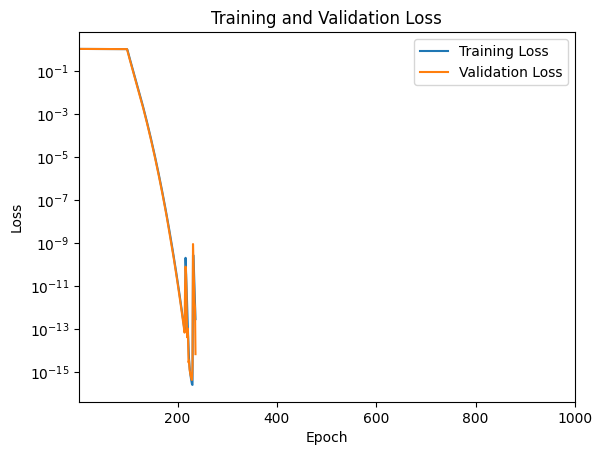

In [21]:
train_loss = history.history['loss'][1:1000]
val_loss = history.history['val_loss'][1:1000]

output_dir = 'plots(100x100)/plots-STA-LSTM'
os.makedirs(output_dir, exist_ok=True)

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.xlim(1, 1000)  # Force the x-axis scale to be from 1 to 1500
plot_filename = f'loss.png'
plot_path = os.path.join(output_dir, plot_filename)
plt.savefig(plot_path)
plt.show()

**Plot the actual against the predicted values for all 6 cytokines at t=82**

0


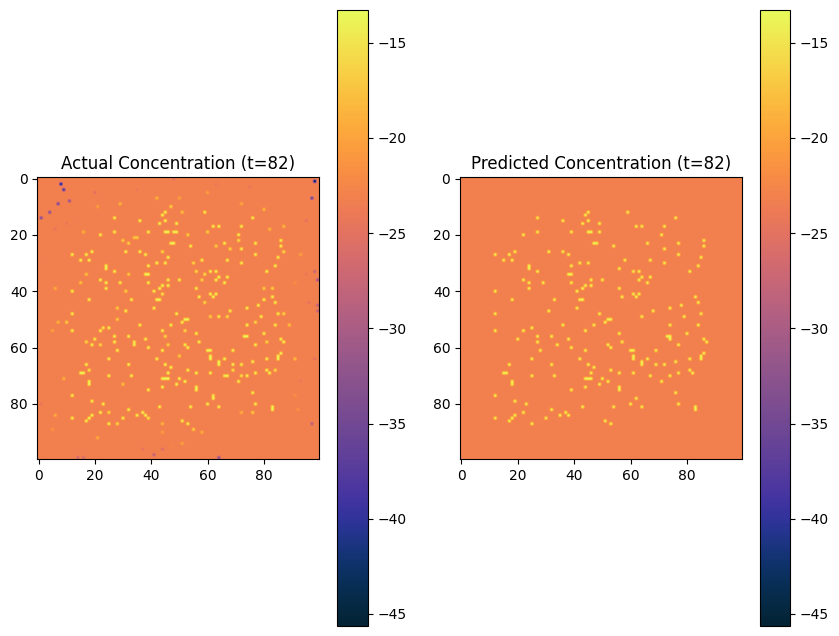

In [27]:
# Flatten the y_pred and y_test tensors
y_pred_shape = y_pred.shape
y_test_shape = y_test.shape

y_pred_flattened = np.reshape(y_pred, (y_pred_shape[0], -1, y_pred_shape[-1]))
y_test_flattened = np.reshape(y_test, (y_test_shape[0], -1, y_test_shape[-1]))

# Calculate the mean squared error for each timestep
mse = np.mean((y_pred_flattened - y_test_flattened) ** 2, axis=(1, 2))

# Find the timestep with the smallest error
best_timestep = np.argmin(mse)
print(best_timestep)

# Get the flattened values for the best timestep
best_y_pred_flattened = y_pred_flattened[best_timestep]
best_y_test_flattened = y_test_flattened[best_timestep]

# Handle zero or negative values before log transformation
epsilon = 1e-10  # Small constant to avoid log(0)
best_y_pred_flattened = np.where(best_y_pred_flattened <= 0, epsilon, best_y_pred_flattened)
best_y_test_flattened = np.where(best_y_test_flattened <= 0, epsilon, best_y_test_flattened)

# Calculate vmin and vmax before reshaping and log transformation
vmin = min(best_y_test_flattened.min(), best_y_pred_flattened.min())
vmax = max(best_y_test_flattened.max(), best_y_pred_flattened.max())

# Apply log scale
log_y_test_flattened = np.log(best_y_test_flattened)
log_y_pred_flattened = np.log(best_y_pred_flattened)

# Reshape the feature data to a 50x50 grid
y_test_grid = np.reshape(log_y_test_flattened[:, 0], (100, 100))
y_pred_grid = np.reshape(log_y_pred_flattened[:, 0], (100, 100))

# Update vmin and vmax to handle log transformation correctly
vmin = min(y_test_grid.min(), y_pred_grid.min())
vmax = max(y_test_grid.max(), y_pred_grid.max())

plt.figure(figsize=(10, 8))

# Plotting actual values
plt.subplot(1, 2, 1)
im1 = plt.imshow(y_test_grid, cmap=cmocean.cm.thermal, vmin=vmin, vmax=vmax)
plt.title('Actual Concentration (t=82)')
plt.colorbar(im1)

# Plotting predicted values
plt.subplot(1, 2, 2)
im2 = plt.imshow(y_pred_grid, cmap=cmocean.cm.thermal, vmin=vmin, vmax=vmax)
plt.title('Predicted Concentration (t=82)')
plt.colorbar(im2)

# Save the plot to the specified folder
output_dir = 'plots(100x100)/plots-STA-LSTM'
plot_filename = f'{0+1}_grid at t=82.png'
plot_path = os.path.join(output_dir, plot_filename)
plt.savefig(plot_path)
plt.show()

**Plot the actual against the predicted values for all 6 cytokines at t=92, t=100**

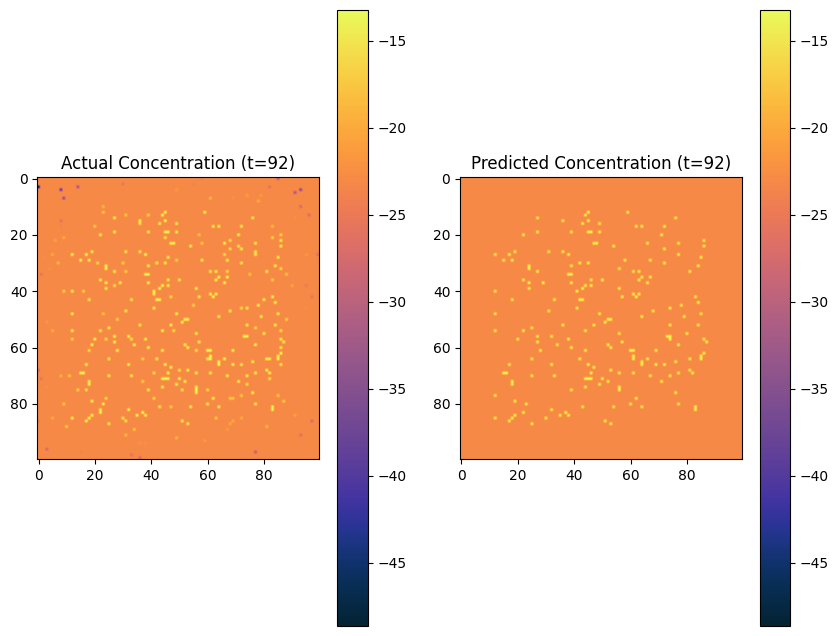

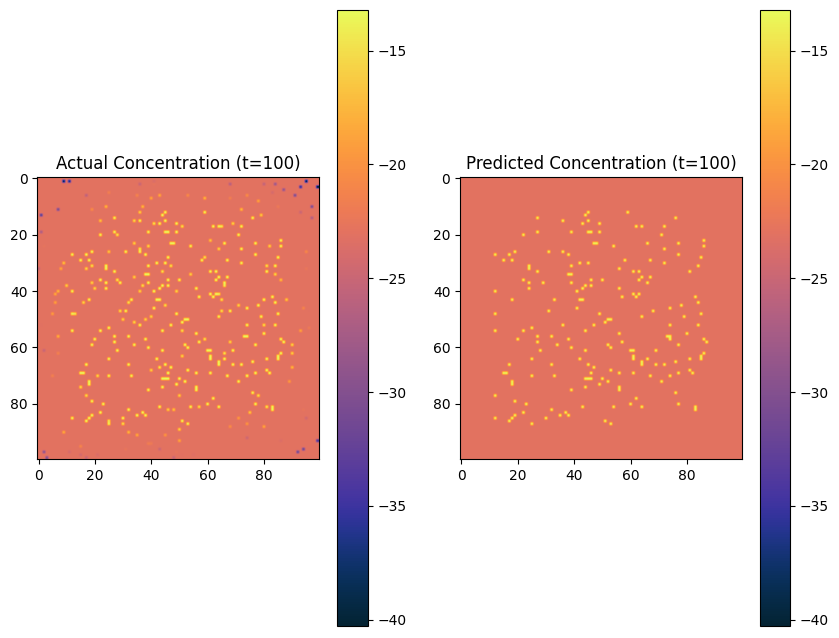

In [28]:
timesteps = [10, 18]

# Flatten the y_pred and y_test tensors
y_pred_shape = y_pred.shape
y_test_shape = y_test.shape

y_pred_flattened = np.reshape(y_pred, (y_pred_shape[0], -1, y_pred_shape[-1]))
y_test_flattened = np.reshape(y_test, (y_test_shape[0], -1, y_test_shape[-1]))

# Handle zero or negative values before log transformation
epsilon = 1e-10  # Small constant to avoid log(0)

for t in timesteps:
    # Get the flattened values for the specified timestep
    y_pred_timestep = y_pred_flattened[t]
    y_test_timestep = y_test_flattened[t]

    # Avoid log(0) by replacing non-positive values
    y_pred_timestep = np.where(y_pred_timestep <= 0, epsilon, y_pred_timestep)
    y_test_timestep = np.where(y_test_timestep <= 0, epsilon, y_test_timestep)

    # Apply log scale
    log_y_test_flattened = np.log(y_test_timestep)
    log_y_pred_flattened = np.log(y_pred_timestep)

    # Reshape the feature data to a 50x50 grid
    y_test_grid = np.reshape(log_y_test_flattened[:, 0], (100, 100))
    y_pred_grid = np.reshape(log_y_pred_flattened[:, 0], (100, 100))

    # Calculate vmin and vmax to handle log transformation correctly
    vmin = min(y_test_grid.min(), y_pred_grid.min())
    vmax = max(y_test_grid.max(), y_pred_grid.max())

    plt.figure(figsize=(10, 8))

    # Plotting actual values
    plt.subplot(1, 2, 1)
    im1 = plt.imshow(y_test_grid, cmap=cmocean.cm.thermal, vmin=vmin, vmax=vmax)
    plt.title(f'Actual Concentration (t={t+82})')
    plt.colorbar(im1)

    # Plotting predicted values
    plt.subplot(1, 2, 2)
    im2 = plt.imshow(y_pred_grid, cmap=cmocean.cm.thermal, vmin=vmin, vmax=vmax)
    plt.title(f'Predicted Concentration (t={t+82})')
    plt.colorbar(im2)

    # Save the plot to the specified folder
    output_dir = 'plots(100x100)/plots-STA-LSTM'
    plot_filename = f'{timesteps.index(t) + 1}_grid at t={t+82}.png'
    plot_path = os.path.join(output_dir, plot_filename)
    plt.savefig(plot_path)
    plt.show()

**Plot the actual against the predicted values for all 6 cytokines at t=72 (here i reran the model and changed the train/test split to generate this timestep so have to run each model twice for this plot)**

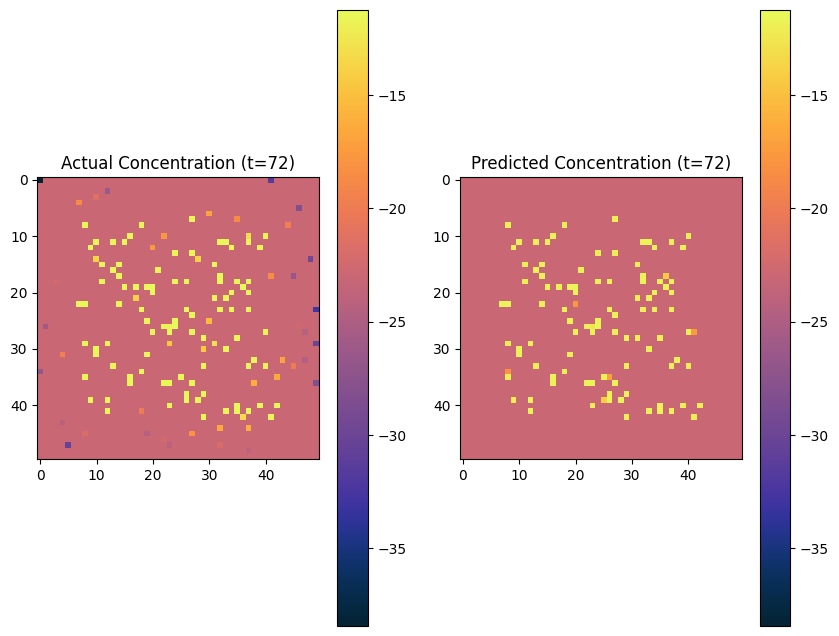

In [37]:
timesteps = [0]

# Flatten the y_pred and y_test tensors
y_pred_shape = y_pred.shape
y_test_shape = y_test.shape

y_pred_flattened = np.reshape(y_pred, (y_pred_shape[0], -1, y_pred_shape[-1]))
y_test_flattened = np.reshape(y_test, (y_test_shape[0], -1, y_test_shape[-1]))

# Handle zero or negative values before log transformation
epsilon = 1e-10  # Small constant to avoid log(0)

for t in timesteps:
    # Get the flattened values for the specified timestep
    y_pred_timestep = y_pred_flattened[t]
    y_test_timestep = y_test_flattened[t]

    # Avoid log(0) by replacing non-positive values
    y_pred_timestep = np.where(y_pred_timestep <= 0, epsilon, y_pred_timestep)
    y_test_timestep = np.where(y_test_timestep <= 0, epsilon, y_test_timestep)

    # Apply log scale
    log_y_test_flattened = np.log(y_test_timestep)
    log_y_pred_flattened = np.log(y_pred_timestep)

    # Reshape the feature data to a 50x50 grid
    y_test_grid = np.reshape(log_y_test_flattened[:, 0], (100, 100))
    y_pred_grid = np.reshape(log_y_pred_flattened[:, 0], (100, 100))

    # Calculate vmin and vmax to handle log transformation correctly
    vmin = min(y_test_grid.min(), y_pred_grid.min())
    vmax = max(y_test_grid.max(), y_pred_grid.max())

    plt.figure(figsize=(10, 8))

    # Plotting actual values
    plt.subplot(1, 2, 1)
    im1 = plt.imshow(y_test_grid, cmap=cmocean.cm.thermal, vmin=vmin, vmax=vmax)
    plt.title(f'Actual Concentration (t={t+72})')
    plt.colorbar(im1)

    # Plotting predicted values
    plt.subplot(1, 2, 2)
    im2 = plt.imshow(y_pred_grid, cmap=cmocean.cm.thermal, vmin=vmin, vmax=vmax)
    plt.title(f'Predicted Concentration (t={t+72})')
    plt.colorbar(im2)

    # Save the plot to the specified folder
    output_dir = 'plots(100x100)/plots-STA-LSTM'
    plot_filename = f'{timesteps.index(t) + 1}_grid at t={t+72}.png'
    plot_path = os.path.join(output_dir, plot_filename)
    plt.savefig(plot_path)
    plt.show()

**Plot actual vs predicted (blue) and actual vs actual (red) for best timestep in test set after flattening**

In [31]:
y_pred=model.predict(X_test)
y_pred_shape = y_pred.shape
y_test_shape = y_test.shape

# Flatten the y_pred and y_test tensors
y_pred_flattened = np.reshape(y_pred, (y_pred_shape[0], -1, y_pred_shape[-1]))
y_test_flattened = np.reshape(y_test, (y_test_shape[0], -1, y_test_shape[-1]))

# Calculate the mean squared error for each timestep
mse = np.mean((y_pred_flattened - y_test_flattened) ** 2, axis=(1, 2))

# Find the timestep with the smallest error
best_timestep = np.argmin(mse)
print(best_timestep)

# Get the flattened values for the best timestep
best_y_pred_flattened = y_pred_flattened[best_timestep]
best_y_test_flattened = y_test_flattened[best_timestep]

# Create arrays for x and y coordinates for the best timestep
X = np.repeat(np.arange(y_test_shape[1]), y_test_shape[2])
Y = np.tile(np.arange(y_test_shape[2]), y_test_shape[1])

# Verify shapes
print(best_y_test_flattened.shape)
print(best_y_pred_flattened.shape)

# Create plots for the best timestep
output_dir = 'plots(100x100)/plots-STA-LSTM'
os.makedirs(output_dir, exist_ok=True)

labels = ['il-8', 'il-1', 'il-6', 'il-10', 'tnf', 'tgf']

num_features = best_y_test_flattened.shape[1]
for i in range(num_features):
    plt.figure(figsize=(6, 4))
    plt.scatter(best_y_test_flattened[:, i], best_y_pred_flattened[:, i], color='blue', alpha=0.5, label='Predicted')
    plt.scatter(best_y_test_flattened[:, i], best_y_test_flattened[:, i], color='red', alpha=0.5, label='Actual')
    plt.title(f'{labels[i]} at Timestep t=82')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    
    # Save the plot to the specified folder
    plot_filename = f'{labels[i]}_at_timestep_t=82.png'
    plot_path = os.path.join(output_dir, plot_filename)
    plt.savefig(plot_path)
    
    plt.show()

1/1 [==============================] - 0s 37ms/step


ValueError: operands could not be broadcast together with shapes (19,10,60000) (19,10000,6) 

**Plot actual vs predicted (blue) and actual vs actual (red) for all the timesteps in the test set after flattening**

1/1 [==============================] - 0s 35ms/step
(19, 100, 100, 6)
(19, 10, 60000)
(190000, 6)
(190, 60000)


ValueError: x and y must be the same size

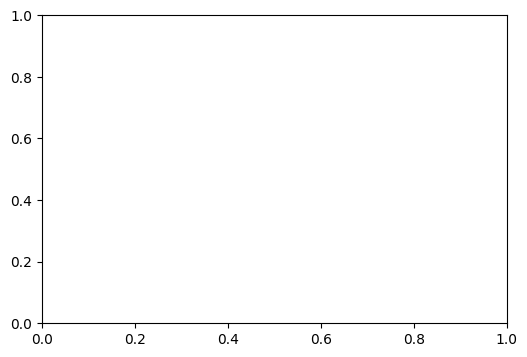

In [32]:
y_pred=model.predict(X_test)
print(y_test.shape)
print(y_pred.shape)
y_pred_shape = y_pred.shape
y_test_shape=y_test.shape

# reshape the tensor to (91*50*50, 6)
y_pred_flattened = np.reshape(y_pred, (-1, y_pred_shape[-1]))
y_test_flattened = np.reshape(y_test, (-1, y_test_shape[-1]))

df = pd.DataFrame(y_pred_flattened, columns=[f'feature_{i+1}' for i in range(y_pred_shape[-1])])

print(y_test_flattened.shape)
print(y_pred_flattened.shape)

output_dir = 'plots(100x100)/plots-STA-LSTM'
os.makedirs(output_dir, exist_ok=True)

labels = ['il-8', 'il-1', 'il-6', 'il-10', 'tnf', 'tgf']

num_features = y_test_flattened.shape[1]
for i in range(num_features):
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test_flattened[:, i], y_pred_flattened[:, i], color='blue', alpha=0.5, label='Predicted')
    plt.scatter(y_test_flattened[:, i], y_test_flattened[:, i], color='red', alpha=0.5, label='Actual')
    plt.title(f'{labels[i]} over entire test set')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    
    # save the plot to the specified folder
    plot_filename = f'{labels[i]}(t=82 to t=100).png'
    plot_path = os.path.join(output_dir, plot_filename)
    plt.savefig(plot_path)
    
    plt.show()

**Time series plot calculating mean and std**

In [33]:
# Combine y_test and y_pred for easier range calculation
combined_data = np.concatenate([y_test, y_pred])

output_dir = 'plots(100x100)/plots-STA-LSTM'
os.makedirs(output_dir, exist_ok=True)

# Mask zeros and small values, set lower limit for log scale
masked_data = np.ma.masked_equal(combined_data, 0)
lower_limit = 1e-13

# Calculate min and max values for each cytokine, ignoring zeros and clipping
min_values = np.ma.min(masked_data, axis=(0, 1, 2))
max_values = np.ma.max(masked_data, axis=(0, 1, 2))

# Convert masked arrays to regular arrays with NaN where masked
min_values = min_values.filled(np.nan)
max_values = max_values.filled(np.nan)

# Average over the spatial dimensions (X, Y coordinates)
y_test_avg = np.mean(y_test, axis=(1, 2))
y_pred_avg = np.mean(y_pred, axis=(1, 2))

# Calculate mean and std for each cytokine across all time steps
y_test_mean = np.mean(y_test_avg, axis=0)
y_pred_mean = np.mean(y_pred_avg, axis=0)
y_test_std = np.std(y_test_avg, axis=0)
y_pred_std = np.std(y_pred_avg, axis=0)

# Time steps (assuming they are from t=82 to t=100)
time_steps = np.arange(82, 101)

labels = ['il-8', 'il-1', 'il-6', 'il-10', 'tnf', 'tgf']

# Plotting
fig, axs = plt.subplots(6, 1, figsize=(12, 18), sharex=True)

for i in range(6):
    axs[i].plot(time_steps, y_test_avg[:, i], label='Actual', marker='o')
    axs[i].plot(time_steps, y_pred_avg[:, i], label='Predicted', marker='x')
    axs[i].set_title(f'{labels[i]} Concentration over Time\nMean ± Std: {y_pred_mean[i]:.2e} ± {y_pred_std[i]:.2e}')
    axs[i].set_ylabel('Concentration (log scale)')
    axs[i].set_yscale('log')
    axs[i].set_ylim(lower_limit, max_values[i])
    axs[i].legend()

axs[-1].set_xlabel('Time Step')

plt.tight_layout()

# save the plot to the specified folder
plot_filename = f'{labels[i]}(t=82 to t=100)(time series plot).png'
plot_path = os.path.join(output_dir, plot_filename)
plt.savefig(plot_path)
plt.show()

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 4 dimension(s) and the array at index 1 has 3 dimension(s)